# Setting Up 4-way-label classification

## Original 

In [ ]:
# Replace the string labels ('True' and 'False') with numerical values (0 and 1), which are better suited for machine learning models.
df2 = df2[df2['2-way-label'].notnull()]
df2['2-way-label'] = df2['2-way-label'].replace({'True': 0, 'False': 1})

## UPDATE
The first code block handles only the 2-way-label, filtering out rows where this column is null and mapping the string labels True and False to numerical values (0 and 1). In contrast, the second code block processes both 2-way-label and 4-way-label. It filters rows where either column is null, ensuring the dataset includes valid labels for both classification tasks. Additionally, it maps the string labels in 4-way-label (e.g., True, Mostly True, etc.) to numerical values (0, 1, 2, 3) using a dedicated mapping, while also remapping the 2-way-label in the same way as the first block. The second block is more comprehensive and supports multi-class classification.

In [ ]:
# Filter out rows with null values in labels
df2 = df2[df2['2-way-label'].notnull()]
df2 = df2[df2['4-way-label'].notnull()]

# Replace string labels with numerical values
label_mapping_2way = {'True': 0, 'False': 1}
label_mapping_4way = {
    "True": 0,
    "Mostly True": 1,
    "Mostly False": 2,
    "False": 3
}

df2['2-way-label'] = df2['2-way-label'].replace(label_mapping_2way)
df2['4-way-label'] = df2['4-way-label'].replace(label_mapping_4way)

# Visual for new mapping

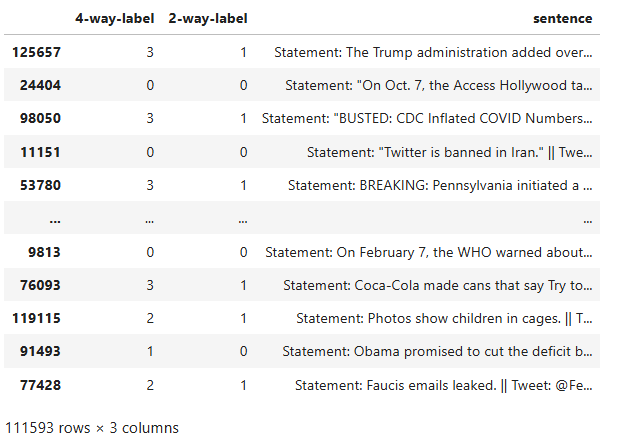

# Validating that the 4-way-labels are balanced  

```
# Count the number of items in each label for both datasets
train_label_counts = {label: 0 for label in range(4)}
val_label_counts = {label: 0 for label in range(4)}

for idx in train_indices:
    label = dataset[idx][2].item()  # Access the label
    train_label_counts[label] += 1

for idx in val_indices:
    label = dataset[idx][2].item()  # Access the label
    val_label_counts[label] += 1

print("Training samples by label:")
for label, count in train_label_counts.items():
    print(f"Label {label}: {count}")

print("Validation samples by label:")
for label, count in val_label_counts.items():
    print(f"Label {label}: {count}")
```
```
89,273 training samples
22,320 validation samples
Training samples by label:
Label 0: 22620
Label 1: 23323
Label 2: 22034
Label 3: 21296
Validation samples by label:
Label 0: 5655
Label 1: 5831
Label 2: 5509
Label 3: 5325


# Original

In [ ]:
  # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        total_fake_examples += (b_labels == 1).sum().item()
        total_true_examples += (b_labels == 0).sum().item()

## UPDATE
The difference between the two code blocks lies in how they define and count "fake" and "true" examples based on the labels (b_labels).

First Block:

Counts "fake" examples as those where b_labels == 1.
Counts "true" examples as those where b_labels == 0.
This is suited for a binary classification task where there are only two possible labels (0 and 1), with 0 representing "true" and 1 representing "fake."
Second Block:

Counts "fake" examples as those where b_labels equals 2 or 3 (b_labels == 2 or b_labels == 3).
Counts "true" examples as those where b_labels equals 0 or 1 (b_labels == 0 or b_labels == 1).
This is suited for a multi-class classification task (e.g., 4-way classification), where labels 0 and 1 are treated as "true," and labels 2 and 3 are treated as "fake."
The second block expands the classification logic to handle multi-class labels, whereas the first block assumes a binary classification problem.

In [ ]:
  # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(torch.int64).to(device)
        total_fake_examples += ((b_labels == 2) | (b_labels == 3)).sum().item()
        total_true_examples += ((b_labels == 0) | (b_labels == 1)).sum().item()

# Original

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)  # Set the random seed
# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

# UPDATE
Update for Stratified Split
Group Data by Label: Separate your dataset into subsets, one for each label.

Split Each Subset: For each label, split the data into 80% training and 20% validation
Maintain Proportions: Ensures that the proportion of samples for each label in training and validation is consistent with the overall dataset distribution.
Avoid Bias: Prevents scenarios where certain labels are overrepresented or missing in either the training or validation set.



In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Group data by label
label_indices = {label: [] for label in range(4)}  # Assuming labels are [0, 1, 2, 3]
for idx, (_, _, label) in enumerate(dataset):
    label_indices[label.item()].append(idx)

# Perform stratified split
train_indices = []
val_indices = []

for label, indices in label_indices.items():
    train_idx, val_idx = train_test_split(
        indices, test_size=0.2, random_state=42  # 80-20 split
    )
    train_indices.extend(train_idx)
    val_indices.extend(val_idx)

# Create train and validation datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

 # Initial Run

```
======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,790.    Elapsed: 0:00:13. Training loss. 0.6781517267227173 Num fake examples 626 Num true examples 654
  Batch    80  of  2,790.    Elapsed: 0:00:26. Training loss. 0.6263445615768433 Num fake examples 1272 Num true examples 1288
  Batch   120  of  2,790.    Elapsed: 0:00:40. Training loss. 0.5697269439697266 Num fake examples 1901 Num true examples 1939
  Batch   160  of  2,790.    Elapsed: 0:00:55. Training loss. 0.5543661713600159 Num fake examples 2555 Num true examples 2565
  Batch   200  of  2,790.    Elapsed: 0:01:09. Training loss. 0.5478495359420776 Num fake examples 3178 Num true examples 3222
  Batch   240  of  2,790.    Elapsed: 0:01:24. Training loss. 0.544278621673584 Num fake examples 3801 Num true examples 3879
  Batch   280  of  2,790.    Elapsed: 0:01:38. Training loss. 0.5507753491401672 Num fake examples 4440 Num true examples 4520
  Batch   320  of  2,790.    Elapsed: 0:01:53. Training loss. 0.4484952390193939 Num fake examples 5086 Num true examples 5154
  Batch   360  of  2,790.    Elapsed: 0:02:07. Training loss. 0.5034416317939758 Num fake examples 5704 Num true examples 5816
  Batch   400  of  2,790.    Elapsed: 0:02:22. Training loss. 0.46799248456954956 Num fake examples 6360 Num true examples 6440
  Batch   440  of  2,790.    Elapsed: 0:02:36. Training loss. 0.3932987451553345 Num fake examples 7013 Num true examples 7067
  Batch   480  of  2,790.    Elapsed: 0:02:51. Training loss. 0.4610861539840698 Num fake examples 7643 Num true examples 7717
  Batch   520  of  2,790.    Elapsed: 0:03:05. Training loss. 0.4305168390274048 Num fake examples 8253 Num true examples 8387
  Batch   560  of  2,790.    Elapsed: 0:03:20. Training loss. 0.46817123889923096 Num fake examples 8881 Num true examples 9039
  Batch   600  of  2,790.    Elapsed: 0:03:34. Training loss. 0.4384930729866028 Num fake examples 9526 Num true examples 9674
  Batch   640  of  2,790.    Elapsed: 0:03:48. Training loss. 0.3682554364204407 Num fake examples 10166 Num true examples 10314
  Batch   680  of  2,790.    Elapsed: 0:04:03. Training loss. 0.37608587741851807 Num fake examples 10768 Num true examples 10992
  Batch   720  of  2,790.    Elapsed: 0:04:17. Training loss. 0.3884163200855255 Num fake examples 11382 Num true examples 11658
  Batch   760  of  2,790.    Elapsed: 0:04:32. Training loss. 0.41368430852890015 Num fake examples 11996 Num true examples 12324
  Batch   800  of  2,790.    Elapsed: 0:04:46. Training loss. 0.41437166929244995 Num fake examples 12618 Num true examples 12982
  Batch   840  of  2,790.    Elapsed: 0:05:00. Training loss. 0.37055325508117676 Num fake examples 13228 Num true examples 13652
  Batch   880  of  2,790.    Elapsed: 0:05:15. Training loss. 0.37747693061828613 Num fake examples 13863 Num true examples 14297
  Batch   920  of  2,790.    Elapsed: 0:05:29. Training loss. 0.3780974745750427 Num fake examples 14462 Num true examples 14978
  Batch   960  of  2,790.    Elapsed: 0:05:43. Training loss. 0.38515764474868774 Num fake examples 15086 Num true examples 15634
  Batch 1,000  of  2,790.    Elapsed: 0:05:58. Training loss. 0.3638369143009186 Num fake examples 15746 Num true examples 16254
  Batch 1,040  of  2,790.    Elapsed: 0:06:12. Training loss. 0.4384477138519287 Num fake examples 16368 Num true examples 16912
  Batch 1,080  of  2,790.    Elapsed: 0:06:27. Training loss. 0.3641906976699829 Num fake examples 17027 Num true examples 17533
  Batch 1,120  of  2,790.    Elapsed: 0:06:41. Training loss. 0.3745090961456299 Num fake examples 17652 Num true examples 18188
  Batch 1,160  of  2,790.    Elapsed: 0:06:55. Training loss. 0.39855149388313293 Num fake examples 18270 Num true examples 18850
  Batch 1,200  of  2,790.    Elapsed: 0:07:10. Training loss. 0.38893699645996094 Num fake examples 18878 Num true examples 19522
  Batch 1,240  of  2,790.    Elapsed: 0:07:24. Training loss. 0.3776392340660095 Num fake examples 19504 Num true examples 20176
  Batch 1,280  of  2,790.    Elapsed: 0:07:39. Training loss. 0.36323657631874084 Num fake examples 20154 Num true examples 20806
  Batch 1,320  of  2,790.    Elapsed: 0:07:53. Training loss. 0.3542647957801819 Num fake examples 20759 Num true examples 21481
  Batch 1,360  of  2,790.    Elapsed: 0:08:07. Training loss. 0.41861966252326965 Num fake examples 21388 Num true examples 22132
  Batch 1,400  of  2,790.    Elapsed: 0:08:22. Training loss. 0.3559756577014923 Num fake examples 21979 Num true examples 22821
  Batch 1,440  of  2,790.    Elapsed: 0:08:36. Training loss. 0.3806708753108978 Num fake examples 22588 Num true examples 23492
  Batch 1,480  of  2,790.    Elapsed: 0:08:51. Training loss. 0.3910355567932129 Num fake examples 23208 Num true examples 24152
  Batch 1,520  of  2,790.    Elapsed: 0:09:05. Training loss. 0.36069151759147644 Num fake examples 23826 Num true examples 24814
  Batch 1,560  of  2,790.    Elapsed: 0:09:19. Training loss. 0.38510432839393616 Num fake examples 24461 Num true examples 25459
  Batch 1,600  of  2,790.    Elapsed: 0:09:34. Training loss. 0.4125412702560425 Num fake examples 25072 Num true examples 26128
  Batch 1,640  of  2,790.    Elapsed: 0:09:48. Training loss. 0.4777345657348633 Num fake examples 25652 Num true examples 26828
  Batch 1,680  of  2,790.    Elapsed: 0:10:03. Training loss. 0.35409289598464966 Num fake examples 26291 Num true examples 27469
  Batch 1,720  of  2,790.    Elapsed: 0:10:17. Training loss. 0.3476731777191162 Num fake examples 26879 Num true examples 28161
  Batch 1,760  of  2,790.    Elapsed: 0:10:31. Training loss. 0.3598805069923401 Num fake examples 27506 Num true examples 28814
  Batch 1,800  of  2,790.    Elapsed: 0:10:46. Training loss. 0.41538065671920776 Num fake examples 28093 Num true examples 29507
  Batch 1,840  of  2,790.    Elapsed: 0:11:00. Training loss. 0.3503253757953644 Num fake examples 28729 Num true examples 30151
  Batch 1,880  of  2,790.    Elapsed: 0:11:15. Training loss. 0.38393330574035645 Num fake examples 29345 Num true examples 30815
  Batch 1,920  of  2,790.    Elapsed: 0:11:29. Training loss. 0.39194661378860474 Num fake examples 29972 Num true examples 31468
  Batch 1,960  of  2,790.    Elapsed: 0:11:43. Training loss. 0.4044085741043091 Num fake examples 30579 Num true examples 32141
  Batch 2,000  of  2,790.    Elapsed: 0:11:58. Training loss. 0.4146804213523865 Num fake examples 31200 Num true examples 32800
  Batch 2,040  of  2,790.    Elapsed: 0:12:12. Training loss. 0.34644967317581177 Num fake examples 31814 Num true examples 33466
  Batch 2,080  of  2,790.    Elapsed: 0:12:27. Training loss. 0.44603127241134644 Num fake examples 32437 Num true examples 34123
  Batch 2,120  of  2,790.    Elapsed: 0:12:41. Training loss. 0.3640744686126709 Num fake examples 33061 Num true examples 34779
  Batch 2,160  of  2,790.    Elapsed: 0:12:55. Training loss. 0.401137113571167 Num fake examples 33684 Num true examples 35436
  Batch 2,200  of  2,790.    Elapsed: 0:13:10. Training loss. 0.4253925085067749 Num fake examples 34322 Num true examples 36078
  Batch 2,240  of  2,790.    Elapsed: 0:13:24. Training loss. 0.44358253479003906 Num fake examples 34957 Num true examples 36723
  Batch 2,280  of  2,790.    Elapsed: 0:13:39. Training loss. 0.3930598497390747 Num fake examples 35570 Num true examples 37390
  Batch 2,320  of  2,790.    Elapsed: 0:13:53. Training loss. 0.4092983305454254 Num fake examples 36210 Num true examples 38030
  Batch 2,360  of  2,790.    Elapsed: 0:14:07. Training loss. 0.38426828384399414 Num fake examples 36824 Num true examples 38696
  Batch 2,400  of  2,790.    Elapsed: 0:14:22. Training loss. 0.36689963936805725 Num fake examples 37449 Num true examples 39351
  Batch 2,440  of  2,790.    Elapsed: 0:14:36. Training loss. 0.40770453214645386 Num fake examples 38097 Num true examples 39983
  Batch 2,480  of  2,790.    Elapsed: 0:14:51. Training loss. 0.4199489951133728 Num fake examples 38710 Num true examples 40650
  Batch 2,520  of  2,790.    Elapsed: 0:15:05. Training loss. 0.41935622692108154 Num fake examples 39333 Num true examples 41307
  Batch 2,560  of  2,790.    Elapsed: 0:15:19. Training loss. 0.3839372396469116 Num fake examples 39946 Num true examples 41974
  Batch 2,600  of  2,790.    Elapsed: 0:15:34. Training loss. 0.35433733463287354 Num fake examples 40564 Num true examples 42636
  Batch 2,640  of  2,790.    Elapsed: 0:15:48. Training loss. 0.3843673765659332 Num fake examples 41155 Num true examples 43325
  Batch 2,680  of  2,790.    Elapsed: 0:16:03. Training loss. 0.3867602050304413 Num fake examples 41765 Num true examples 43995
  Batch 2,720  of  2,790.    Elapsed: 0:16:17. Training loss. 0.38932496309280396 Num fake examples 42362 Num true examples 44678
  Batch 2,760  of  2,790.    Elapsed: 0:16:31. Training loss. 0.36200636625289917 Num fake examples 43003 Num true examples 45317

  Average training loss: 0.42
  Training epcoh took: 0:16:42

Running Validation...
  Accuracy: 0.49
  Validation Loss: 0.39
  Validation took: 0:01:41

======== Epoch 2 / 4 ========
Training...
  Batch    40  of  2,790.    Elapsed: 0:00:14. Training loss. 0.3862661123275757 Num fake examples 617 Num true examples 663
  Batch    80  of  2,790.    Elapsed: 0:00:28. Training loss. 0.40898340940475464 Num fake examples 1287 Num true examples 1273
  Batch   120  of  2,790.    Elapsed: 0:00:43. Training loss. 0.382870614528656 Num fake examples 1891 Num true examples 1949
  Batch   160  of  2,790.    Elapsed: 0:00:57. Training loss. 0.42571502923965454 Num fake examples 2517 Num true examples 2603
  Batch   200  of  2,790.    Elapsed: 0:01:11. Training loss. 0.39149901270866394 Num fake examples 3140 Num true examples 3260
  Batch   240  of  2,790.    Elapsed: 0:01:26. Training loss. 0.38351964950561523 Num fake examples 3738 Num true examples 3942
  Batch   280  of  2,790.    Elapsed: 0:01:40. Training loss. 0.39729368686676025 Num fake examples 4364 Num true examples 4596
  Batch   320  of  2,790.    Elapsed: 0:01:54. Training loss. 0.4096594750881195 Num fake examples 4957 Num true examples 5283
  Batch   360  of  2,790.    Elapsed: 0:02:09. Training loss. 0.3898468613624573 Num fake examples 5579 Num true examples 5941
  Batch   400  of  2,790.    Elapsed: 0:02:23. Training loss. 0.4085986912250519 Num fake examples 6208 Num true examples 6592
  Batch   440  of  2,790.    Elapsed: 0:02:38. Training loss. 0.4030081629753113 Num fake examples 6819 Num true examples 7261
  Batch   480  of  2,790.    Elapsed: 0:02:52. Training loss. 0.42958420515060425 Num fake examples 7450 Num true examples 7910
  Batch   520  of  2,790.    Elapsed: 0:03:06. Training loss. 0.37894532084465027 Num fake examples 8077 Num true examples 8563
  Batch   560  of  2,790.    Elapsed: 0:03:21. Training loss. 0.43188297748565674 Num fake examples 8733 Num true examples 9187
  Batch   600  of  2,790.    Elapsed: 0:03:35. Training loss. 0.41569072008132935 Num fake examples 9351 Num true examples 9849
  Batch   640  of  2,790.    Elapsed: 0:03:50. Training loss. 0.3587392568588257 Num fake examples 9980 Num true examples 10500
  Batch   680  of  2,790.    Elapsed: 0:04:04. Training loss. 0.5044633150100708 Num fake examples 10592 Num true examples 11168
  Batch   720  of  2,790.    Elapsed: 0:04:18. Training loss. 0.38499778509140015 Num fake examples 11206 Num true examples 11834
  Batch   760  of  2,790.    Elapsed: 0:04:33. Training loss. 0.44871851801872253 Num fake examples 11817 Num true examples 12503
  Batch   800  of  2,790.    Elapsed: 0:04:47. Training loss. 0.3398191034793854 Num fake examples 12440 Num true examples 13160
  Batch   840  of  2,790.    Elapsed: 0:05:01. Training loss. 0.41533541679382324 Num fake examples 13039 Num true examples 13841
  Batch   880  of  2,790.    Elapsed: 0:05:16. Training loss. 0.36297762393951416 Num fake examples 13682 Num true examples 14478
  Batch   920  of  2,790.    Elapsed: 0:05:30. Training loss. 0.39462000131607056 Num fake examples 14326 Num true examples 15114
  Batch   960  of  2,790.    Elapsed: 0:05:45. Training loss. 0.3537713885307312 Num fake examples 14958 Num true examples 15762
  Batch 1,000  of  2,790.    Elapsed: 0:05:59. Training loss. 0.3590540289878845 Num fake examples 15589 Num true examples 16411
  Batch 1,040  of  2,790.    Elapsed: 0:06:13. Training loss. 0.41121906042099 Num fake examples 16198 Num true examples 17082
  Batch 1,080  of  2,790.    Elapsed: 0:06:28. Training loss. 0.3936556577682495 Num fake examples 16843 Num true examples 17717
  Batch 1,120  of  2,790.    Elapsed: 0:06:42. Training loss. 0.39968013763427734 Num fake examples 17449 Num true examples 18391
  Batch 1,160  of  2,790.    Elapsed: 0:06:56. Training loss. 0.37805408239364624 Num fake examples 18082 Num true examples 19038
  Batch 1,200  of  2,790.    Elapsed: 0:07:11. Training loss. 0.37859636545181274 Num fake examples 18716 Num true examples 19684
  Batch 1,240  of  2,790.    Elapsed: 0:07:25. Training loss. 0.37814098596572876 Num fake examples 19394 Num true examples 20286
  Batch 1,280  of  2,790.    Elapsed: 0:07:39. Training loss. 0.3600773811340332 Num fake examples 20038 Num true examples 20922
  Batch 1,320  of  2,790.    Elapsed: 0:07:54. Training loss. 0.39220044016838074 Num fake examples 20683 Num true examples 21557
  Batch 1,360  of  2,790.    Elapsed: 0:08:08. Training loss. 0.5214897394180298 Num fake examples 21318 Num true examples 22202
  Batch 1,400  of  2,790.    Elapsed: 0:08:23. Training loss. 0.35520321130752563 Num fake examples 21936 Num true examples 22864
  Batch 1,440  of  2,790.    Elapsed: 0:08:37. Training loss. 0.38692015409469604 Num fake examples 22526 Num true examples 23554
  Batch 1,480  of  2,790.    Elapsed: 0:08:51. Training loss. 0.35638540983200073 Num fake examples 23187 Num true examples 24173
  Batch 1,520  of  2,790.    Elapsed: 0:09:06. Training loss. 0.3871668577194214 Num fake examples 23798 Num true examples 24842
  Batch 1,560  of  2,790.    Elapsed: 0:09:20. Training loss. 0.3557471036911011 Num fake examples 24429 Num true examples 25491
  Batch 1,600  of  2,790.    Elapsed: 0:09:34. Training loss. 0.35332226753234863 Num fake examples 25031 Num true examples 26169
  Batch 1,640  of  2,790.    Elapsed: 0:09:49. Training loss. 0.44768184423446655 Num fake examples 25636 Num true examples 26844
  Batch 1,680  of  2,790.    Elapsed: 0:10:03. Training loss. 0.3834673762321472 Num fake examples 26257 Num true examples 27503
  Batch 1,720  of  2,790.    Elapsed: 0:10:17. Training loss. 0.4088781476020813 Num fake examples 26865 Num true examples 28175
  Batch 1,760  of  2,790.    Elapsed: 0:10:32. Training loss. 0.3557737171649933 Num fake examples 27497 Num true examples 28823
  Batch 1,800  of  2,790.    Elapsed: 0:10:46. Training loss. 0.3579977750778198 Num fake examples 28084 Num true examples 29516
  Batch 1,840  of  2,790.    Elapsed: 0:11:00. Training loss. 0.392944872379303 Num fake examples 28695 Num true examples 30185
  Batch 1,880  of  2,790.    Elapsed: 0:11:15. Training loss. 0.3550136983394623 Num fake examples 29309 Num true examples 30851
  Batch 1,920  of  2,790.    Elapsed: 0:11:29. Training loss. 0.4261569380760193 Num fake examples 29939 Num true examples 31501
  Batch 1,960  of  2,790.    Elapsed: 0:11:44. Training loss. 0.3647420406341553 Num fake examples 30557 Num true examples 32163
  Batch 2,000  of  2,790.    Elapsed: 0:11:58. Training loss. 0.38166195154190063 Num fake examples 31161 Num true examples 32839
  Batch 2,040  of  2,790.    Elapsed: 0:12:12. Training loss. 0.4088525176048279 Num fake examples 31815 Num true examples 33465
  Batch 2,080  of  2,790.    Elapsed: 0:12:27. Training loss. 0.3502781093120575 Num fake examples 32414 Num true examples 34146
  Batch 2,120  of  2,790.    Elapsed: 0:12:41. Training loss. 0.35526344180107117 Num fake examples 33052 Num true examples 34788
  Batch 2,160  of  2,790.    Elapsed: 0:12:55. Training loss. 0.3896411657333374 Num fake examples 33683 Num true examples 35437
  Batch 2,200  of  2,790.    Elapsed: 0:13:10. Training loss. 0.35127779841423035 Num fake examples 34319 Num true examples 36081
  Batch 2,240  of  2,790.    Elapsed: 0:13:24. Training loss. 0.40530526638031006 Num fake examples 34923 Num true examples 36757
  Batch 2,280  of  2,790.    Elapsed: 0:13:39. Training loss. 0.40398645401000977 Num fake examples 35538 Num true examples 37422
  Batch 2,320  of  2,790.    Elapsed: 0:13:53. Training loss. 0.446648508310318 Num fake examples 36173 Num true examples 38067
  Batch 2,360  of  2,790.    Elapsed: 0:14:07. Training loss. 0.43142029643058777 Num fake examples 36792 Num true examples 38728
  Batch 2,400  of  2,790.    Elapsed: 0:14:22. Training loss. 0.37644386291503906 Num fake examples 37390 Num true examples 39410
  Batch 2,440  of  2,790.    Elapsed: 0:14:36. Training loss. 0.40662646293640137 Num fake examples 38031 Num true examples 40049
  Batch 2,480  of  2,790.    Elapsed: 0:14:50. Training loss. 0.3785971999168396 Num fake examples 38657 Num true examples 40703
  Batch 2,520  of  2,790.    Elapsed: 0:15:05. Training loss. 0.38902974128723145 Num fake examples 39280 Num true examples 41360
  Batch 2,560  of  2,790.    Elapsed: 0:15:19. Training loss. 0.4520447254180908 Num fake examples 39903 Num true examples 42017
  Batch 2,600  of  2,790.    Elapsed: 0:15:34. Training loss. 0.41636818647384644 Num fake examples 40524 Num true examples 42676
  Batch 2,640  of  2,790.    Elapsed: 0:15:48. Training loss. 0.38141757249832153 Num fake examples 41141 Num true examples 43339
  Batch 2,680  of  2,790.    Elapsed: 0:16:02. Training loss. 0.43812838196754456 Num fake examples 41759 Num true examples 44001
  Batch 2,720  of  2,790.    Elapsed: 0:16:17. Training loss. 0.3903948664665222 Num fake examples 42388 Num true examples 44652
  Batch 2,760  of  2,790.    Elapsed: 0:16:31. Training loss. 0.4574216604232788 Num fake examples 43017 Num true examples 45303

  Average training loss: 0.39
  Training epcoh took: 0:16:42

Running Validation...
  Accuracy: 0.50
  Validation Loss: 0.38
  Validation took: 0:01:41

======== Epoch 3 / 4 ========
Training...
  Batch    40  of  2,790.    Elapsed: 0:00:14. Training loss. 0.42790764570236206 Num fake examples 599 Num true examples 681
  Batch    80  of  2,790.    Elapsed: 0:00:28. Training loss. 0.38288629055023193 Num fake examples 1232 Num true examples 1328
  Batch   120  of  2,790.    Elapsed: 0:00:43. Training loss. 0.3820754289627075 Num fake examples 1860 Num true examples 1980
  Batch   160  of  2,790.    Elapsed: 0:00:57. Training loss. 0.3766656816005707 Num fake examples 2500 Num true examples 2620
  Batch   200  of  2,790.    Elapsed: 0:01:11. Training loss. 0.3779357671737671 Num fake examples 3144 Num true examples 3256
  Batch   240  of  2,790.    Elapsed: 0:01:26. Training loss. 0.37868842482566833 Num fake examples 3807 Num true examples 3873
  Batch   280  of  2,790.    Elapsed: 0:01:40. Training loss. 0.4274519085884094 Num fake examples 4447 Num true examples 4513
  Batch   320  of  2,790.    Elapsed: 0:01:55. Training loss. 0.38417065143585205 Num fake examples 5078 Num true examples 5162
  Batch   360  of  2,790.    Elapsed: 0:02:09. Training loss. 0.3894050121307373 Num fake examples 5697 Num true examples 5823
  Batch   400  of  2,790.    Elapsed: 0:02:23. Training loss. 0.43271225690841675 Num fake examples 6335 Num true examples 6465
  Batch   440  of  2,790.    Elapsed: 0:02:38. Training loss. 0.3801209330558777 Num fake examples 6936 Num true examples 7144
  Batch   480  of  2,790.    Elapsed: 0:02:52. Training loss. 0.3919796347618103 Num fake examples 7584 Num true examples 7776
  Batch   520  of  2,790.    Elapsed: 0:03:06. Training loss. 0.377444326877594 Num fake examples 8212 Num true examples 8428
  Batch   560  of  2,790.    Elapsed: 0:03:21. Training loss. 0.3462916612625122 Num fake examples 8797 Num true examples 9123
  Batch   600  of  2,790.    Elapsed: 0:03:35. Training loss. 0.36060935258865356 Num fake examples 9415 Num true examples 9785
  Batch   640  of  2,790.    Elapsed: 0:03:50. Training loss. 0.4455009698867798 Num fake examples 10023 Num true examples 10457
  Batch   680  of  2,790.    Elapsed: 0:04:04. Training loss. 0.3751096725463867 Num fake examples 10660 Num true examples 11100
  Batch   720  of  2,790.    Elapsed: 0:04:18. Training loss. 0.3795713186264038 Num fake examples 11294 Num true examples 11746
  Batch   760  of  2,790.    Elapsed: 0:04:33. Training loss. 0.395809143781662 Num fake examples 11925 Num true examples 12395
  Batch   800  of  2,790.    Elapsed: 0:04:47. Training loss. 0.36231130361557007 Num fake examples 12554 Num true examples 13046
  Batch   840  of  2,790.    Elapsed: 0:05:01. Training loss. 0.355959951877594 Num fake examples 13170 Num true examples 13710
  Batch   880  of  2,790.    Elapsed: 0:05:16. Training loss. 0.3540652394294739 Num fake examples 13777 Num true examples 14383
  Batch   920  of  2,790.    Elapsed: 0:05:30. Training loss. 0.4145311415195465 Num fake examples 14444 Num true examples 14996
  Batch   960  of  2,790.    Elapsed: 0:05:45. Training loss. 0.38638433814048767 Num fake examples 15077 Num true examples 15643
  Batch 1,000  of  2,790.    Elapsed: 0:05:59. Training loss. 0.3895276188850403 Num fake examples 15683 Num true examples 16317
  Batch 1,040  of  2,790.    Elapsed: 0:06:13. Training loss. 0.34967076778411865 Num fake examples 16315 Num true examples 16965
  Batch 1,080  of  2,790.    Elapsed: 0:06:28. Training loss. 0.4427236020565033 Num fake examples 16939 Num true examples 17621
  Batch 1,120  of  2,790.    Elapsed: 0:06:42. Training loss. 0.3735758662223816 Num fake examples 17525 Num true examples 18315
  Batch 1,160  of  2,790.    Elapsed: 0:06:57. Training loss. 0.34933918714523315 Num fake examples 18159 Num true examples 18961
  Batch 1,200  of  2,790.    Elapsed: 0:07:11. Training loss. 0.4135999381542206 Num fake examples 18790 Num true examples 19610
  Batch 1,240  of  2,790.    Elapsed: 0:07:25. Training loss. 0.35876575112342834 Num fake examples 19389 Num true examples 20291
  Batch 1,280  of  2,790.    Elapsed: 0:07:40. Training loss. 0.3523712754249573 Num fake examples 20036 Num true examples 20924
  Batch 1,320  of  2,790.    Elapsed: 0:07:54. Training loss. 0.4569893777370453 Num fake examples 20662 Num true examples 21578
  Batch 1,360  of  2,790.    Elapsed: 0:08:09. Training loss. 0.38683053851127625 Num fake examples 21286 Num true examples 22234
  Batch 1,400  of  2,790.    Elapsed: 0:08:23. Training loss. 0.41372716426849365 Num fake examples 21906 Num true examples 22894
  Batch 1,440  of  2,790.    Elapsed: 0:08:37. Training loss. 0.37208646535873413 Num fake examples 22537 Num true examples 23543
  Batch 1,480  of  2,790.    Elapsed: 0:08:52. Training loss. 0.358352392911911 Num fake examples 23148 Num true examples 24212
  Batch 1,520  of  2,790.    Elapsed: 0:09:06. Training loss. 0.39068907499313354 Num fake examples 23774 Num true examples 24866
  Batch 1,560  of  2,790.    Elapsed: 0:09:21. Training loss. 0.4038681089878082 Num fake examples 24434 Num true examples 25486
  Batch 1,600  of  2,790.    Elapsed: 0:09:35. Training loss. 0.40373694896698 Num fake examples 25035 Num true examples 26165
  Batch 1,640  of  2,790.    Elapsed: 0:09:49. Training loss. 0.4131893217563629 Num fake examples 25667 Num true examples 26813
  Batch 1,680  of  2,790.    Elapsed: 0:10:04. Training loss. 0.44707244634628296 Num fake examples 26301 Num true examples 27459
  Batch 1,720  of  2,790.    Elapsed: 0:10:18. Training loss. 0.3981790542602539 Num fake examples 26930 Num true examples 28110
  Batch 1,760  of  2,790.    Elapsed: 0:10:33. Training loss. 0.3605612814426422 Num fake examples 27567 Num true examples 28753
  Batch 1,800  of  2,790.    Elapsed: 0:10:47. Training loss. 0.3774604797363281 Num fake examples 28151 Num true examples 29449
  Batch 1,840  of  2,790.    Elapsed: 0:11:01. Training loss. 0.3385671079158783 Num fake examples 28768 Num true examples 30112
  Batch 1,880  of  2,790.    Elapsed: 0:11:16. Training loss. 0.3907296657562256 Num fake examples 29363 Num true examples 30797
  Batch 1,920  of  2,790.    Elapsed: 0:11:30. Training loss. 0.35141804814338684 Num fake examples 29977 Num true examples 31463
  Batch 1,960  of  2,790.    Elapsed: 0:11:45. Training loss. 0.3568075895309448 Num fake examples 30570 Num true examples 32150
  Batch 2,000  of  2,790.    Elapsed: 0:11:59. Training loss. 0.395846962928772 Num fake examples 31188 Num true examples 32812
  Batch 2,040  of  2,790.    Elapsed: 0:12:13. Training loss. 0.3489075005054474 Num fake examples 31814 Num true examples 33466
  Batch 2,080  of  2,790.    Elapsed: 0:12:28. Training loss. 0.35141339898109436 Num fake examples 32428 Num true examples 34132
  Batch 2,120  of  2,790.    Elapsed: 0:12:42. Training loss. 0.34870022535324097 Num fake examples 33054 Num true examples 34786
  Batch 2,160  of  2,790.    Elapsed: 0:12:57. Training loss. 0.3635905385017395 Num fake examples 33664 Num true examples 35456
  Batch 2,200  of  2,790.    Elapsed: 0:13:11. Training loss. 0.3654181659221649 Num fake examples 34307 Num true examples 36093
  Batch 2,240  of  2,790.    Elapsed: 0:13:25. Training loss. 0.356902152299881 Num fake examples 34906 Num true examples 36774
  Batch 2,280  of  2,790.    Elapsed: 0:13:40. Training loss. 0.4056021571159363 Num fake examples 35550 Num true examples 37410
  Batch 2,320  of  2,790.    Elapsed: 0:13:54. Training loss. 0.34676843881607056 Num fake examples 36169 Num true examples 38071
  Batch 2,360  of  2,790.    Elapsed: 0:14:09. Training loss. 0.4274623692035675 Num fake examples 36778 Num true examples 38742
  Batch 2,400  of  2,790.    Elapsed: 0:14:23. Training loss. 0.4058724641799927 Num fake examples 37387 Num true examples 39413
  Batch 2,440  of  2,790.    Elapsed: 0:14:37. Training loss. 0.38374704122543335 Num fake examples 37980 Num true examples 40100
  Batch 2,480  of  2,790.    Elapsed: 0:14:52. Training loss. 0.38112106919288635 Num fake examples 38609 Num true examples 40751
  Batch 2,520  of  2,790.    Elapsed: 0:15:06. Training loss. 0.3804210126399994 Num fake examples 39258 Num true examples 41382
  Batch 2,560  of  2,790.    Elapsed: 0:15:21. Training loss. 0.37290796637535095 Num fake examples 39871 Num true examples 42049
  Batch 2,600  of  2,790.    Elapsed: 0:15:35. Training loss. 0.3566984236240387 Num fake examples 40516 Num true examples 42684
  Batch 2,640  of  2,790.    Elapsed: 0:15:49. Training loss. 0.35974228382110596 Num fake examples 41127 Num true examples 43353
  Batch 2,680  of  2,790.    Elapsed: 0:16:04. Training loss. 0.3645686209201813 Num fake examples 41756 Num true examples 44004
  Batch 2,720  of  2,790.    Elapsed: 0:16:18. Training loss. 0.3656904995441437 Num fake examples 42353 Num true examples 44687
  Batch 2,760  of  2,790.    Elapsed: 0:16:33. Training loss. 0.4175812602043152 Num fake examples 42973 Num true examples 45347

  Average training loss: 0.38
  Training epcoh took: 0:16:43

Running Validation...
  Accuracy: 0.51
  Validation Loss: 0.38
  Validation took: 0:01:41

======== Epoch 4 / 4 ========
Training...
  Batch    40  of  2,790.    Elapsed: 0:00:14. Training loss. 0.4225565195083618 Num fake examples 658 Num true examples 622
  Batch    80  of  2,790.    Elapsed: 0:00:28. Training loss. 0.3935213088989258 Num fake examples 1311 Num true examples 1249
  Batch   120  of  2,790.    Elapsed: 0:00:43. Training loss. 0.38003093004226685 Num fake examples 1901 Num true examples 1939
  Batch   160  of  2,790.    Elapsed: 0:00:57. Training loss. 0.4252457022666931 Num fake examples 2551 Num true examples 2569
  Batch   200  of  2,790.    Elapsed: 0:01:11. Training loss. 0.36375489830970764 Num fake examples 3166 Num true examples 3234
  Batch   240  of  2,790.    Elapsed: 0:01:26. Training loss. 0.37673771381378174 Num fake examples 3803 Num true examples 3877
  Batch   280  of  2,790.    Elapsed: 0:01:40. Training loss. 0.4080820679664612 Num fake examples 4441 Num true examples 4519
  Batch   320  of  2,790.    Elapsed: 0:01:54. Training loss. 0.36783474683761597 Num fake examples 5069 Num true examples 5171
  Batch   360  of  2,790.    Elapsed: 0:02:09. Training loss. 0.42126113176345825 Num fake examples 5707 Num true examples 5813
  Batch   400  of  2,790.    Elapsed: 0:02:23. Training loss. 0.35212191939353943 Num fake examples 6333 Num true examples 6467
  Batch   440  of  2,790.    Elapsed: 0:02:37. Training loss. 0.39045828580856323 Num fake examples 6944 Num true examples 7136
  Batch   480  of  2,790.    Elapsed: 0:02:52. Training loss. 0.4527665078639984 Num fake examples 7588 Num true examples 7772
  Batch   520  of  2,790.    Elapsed: 0:03:06. Training loss. 0.3530610203742981 Num fake examples 8219 Num true examples 8421
  Batch   560  of  2,790.    Elapsed: 0:03:20. Training loss. 0.3524516820907593 Num fake examples 8850 Num true examples 9070
  Batch   600  of  2,790.    Elapsed: 0:03:35. Training loss. 0.43077731132507324 Num fake examples 9458 Num true examples 9742
  Batch   640  of  2,790.    Elapsed: 0:03:49. Training loss. 0.38389742374420166 Num fake examples 10070 Num true examples 10410
  Batch   680  of  2,790.    Elapsed: 0:04:04. Training loss. 0.45578664541244507 Num fake examples 10691 Num true examples 11069
  Batch   720  of  2,790.    Elapsed: 0:04:18. Training loss. 0.36289653182029724 Num fake examples 11287 Num true examples 11753
  Batch   760  of  2,790.    Elapsed: 0:04:32. Training loss. 0.3468509018421173 Num fake examples 11890 Num true examples 12430
  Batch   800  of  2,790.    Elapsed: 0:04:47. Training loss. 0.37163519859313965 Num fake examples 12506 Num true examples 13094
  Batch   840  of  2,790.    Elapsed: 0:05:01. Training loss. 0.3543040156364441 Num fake examples 13129 Num true examples 13751
  Batch   880  of  2,790.    Elapsed: 0:05:15. Training loss. 0.3925606906414032 Num fake examples 13765 Num true examples 14395
  Batch   920  of  2,790.    Elapsed: 0:05:30. Training loss. 0.34768420457839966 Num fake examples 14362 Num true examples 15078
  Batch   960  of  2,790.    Elapsed: 0:05:44. Training loss. 0.37259483337402344 Num fake examples 15011 Num true examples 15709
  Batch 1,000  of  2,790.    Elapsed: 0:05:58. Training loss. 0.36220261454582214 Num fake examples 15600 Num true examples 16400
  Batch 1,040  of  2,790.    Elapsed: 0:06:13. Training loss. 0.3525162935256958 Num fake examples 16222 Num true examples 17058
  Batch 1,080  of  2,790.    Elapsed: 0:06:27. Training loss. 0.37029919028282166 Num fake examples 16839 Num true examples 17721
  Batch 1,120  of  2,790.    Elapsed: 0:06:42. Training loss. 0.41004252433776855 Num fake examples 17433 Num true examples 18407
  Batch 1,160  of  2,790.    Elapsed: 0:06:56. Training loss. 0.35565584897994995 Num fake examples 18083 Num true examples 19037
  Batch 1,200  of  2,790.    Elapsed: 0:07:10. Training loss. 0.358317494392395 Num fake examples 18725 Num true examples 19675
  Batch 1,240  of  2,790.    Elapsed: 0:07:25. Training loss. 0.36391720175743103 Num fake examples 19354 Num true examples 20326
  Batch 1,280  of  2,790.    Elapsed: 0:07:39. Training loss. 0.39611053466796875 Num fake examples 19992 Num true examples 20968
  Batch 1,320  of  2,790.    Elapsed: 0:07:53. Training loss. 0.37767261266708374 Num fake examples 20590 Num true examples 21650
  Batch 1,360  of  2,790.    Elapsed: 0:08:08. Training loss. 0.36601346731185913 Num fake examples 21200 Num true examples 22320
  Batch 1,400  of  2,790.    Elapsed: 0:08:22. Training loss. 0.39152994751930237 Num fake examples 21821 Num true examples 22979
  Batch 1,440  of  2,790.    Elapsed: 0:08:36. Training loss. 0.34792065620422363 Num fake examples 22438 Num true examples 23642
  Batch 1,480  of  2,790.    Elapsed: 0:08:51. Training loss. 0.3566075265407562 Num fake examples 23062 Num true examples 24298
  Batch 1,520  of  2,790.    Elapsed: 0:09:05. Training loss. 0.40325725078582764 Num fake examples 23669 Num true examples 24971
  Batch 1,560  of  2,790.    Elapsed: 0:09:19. Training loss. 0.3535035252571106 Num fake examples 24273 Num true examples 25647
  Batch 1,600  of  2,790.    Elapsed: 0:09:34. Training loss. 0.3400809168815613 Num fake examples 24907 Num true examples 26293
  Batch 1,640  of  2,790.    Elapsed: 0:09:48. Training loss. 0.36527925729751587 Num fake examples 25552 Num true examples 26928
  Batch 1,680  of  2,790.    Elapsed: 0:10:03. Training loss. 0.3765728771686554 Num fake examples 26205 Num true examples 27555
  Batch 1,720  of  2,790.    Elapsed: 0:10:17. Training loss. 0.37866002321243286 Num fake examples 26854 Num true examples 28186
  Batch 1,760  of  2,790.    Elapsed: 0:10:31. Training loss. 0.3873828649520874 Num fake examples 27457 Num true examples 28863
  Batch 1,800  of  2,790.    Elapsed: 0:10:46. Training loss. 0.42301812767982483 Num fake examples 28058 Num true examples 29542
  Batch 1,840  of  2,790.    Elapsed: 0:11:00. Training loss. 0.39517146348953247 Num fake examples 28683 Num true examples 30197
  Batch 1,880  of  2,790.    Elapsed: 0:11:14. Training loss. 0.3877638280391693 Num fake examples 29333 Num true examples 30827
  Batch 1,920  of  2,790.    Elapsed: 0:11:29. Training loss. 0.42093420028686523 Num fake examples 29966 Num true examples 31474
  Batch 1,960  of  2,790.    Elapsed: 0:11:43. Training loss. 0.3477022051811218 Num fake examples 30599 Num true examples 32121
  Batch 2,000  of  2,790.    Elapsed: 0:11:58. Training loss. 0.3832406997680664 Num fake examples 31209 Num true examples 32791
  Batch 2,040  of  2,790.    Elapsed: 0:12:12. Training loss. 0.3847275376319885 Num fake examples 31816 Num true examples 33464
  Batch 2,080  of  2,790.    Elapsed: 0:12:26. Training loss. 0.44686731696128845 Num fake examples 32430 Num true examples 34130
  Batch 2,120  of  2,790.    Elapsed: 0:12:41. Training loss. 0.3739515244960785 Num fake examples 33077 Num true examples 34763
  Batch 2,160  of  2,790.    Elapsed: 0:12:55. Training loss. 0.4164060354232788 Num fake examples 33695 Num true examples 35425
  Batch 2,200  of  2,790.    Elapsed: 0:13:09. Training loss. 0.338975191116333 Num fake examples 34336 Num true examples 36064
  Batch 2,240  of  2,790.    Elapsed: 0:13:24. Training loss. 0.44573354721069336 Num fake examples 34960 Num true examples 36720
  Batch 2,280  of  2,790.    Elapsed: 0:13:38. Training loss. 0.3565433621406555 Num fake examples 35582 Num true examples 37378
  Batch 2,320  of  2,790.    Elapsed: 0:13:52. Training loss. 0.390402615070343 Num fake examples 36196 Num true examples 38044
  Batch 2,360  of  2,790.    Elapsed: 0:14:07. Training loss. 0.34158560633659363 Num fake examples 36783 Num true examples 38737
  Batch 2,400  of  2,790.    Elapsed: 0:14:21. Training loss. 0.3550685942173004 Num fake examples 37383 Num true examples 39417
  Batch 2,440  of  2,790.    Elapsed: 0:14:35. Training loss. 0.349115252494812 Num fake examples 37979 Num true examples 40101
  Batch 2,480  of  2,790.    Elapsed: 0:14:50. Training loss. 0.37094205617904663 Num fake examples 38608 Num true examples 40752
  Batch 2,520  of  2,790.    Elapsed: 0:15:04. Training loss. 0.41739729046821594 Num fake examples 39228 Num true examples 41412
  Batch 2,560  of  2,790.    Elapsed: 0:15:18. Training loss. 0.38308826088905334 Num fake examples 39854 Num true examples 42066
  Batch 2,600  of  2,790.    Elapsed: 0:15:33. Training loss. 0.38343578577041626 Num fake examples 40464 Num true examples 42736
  Batch 2,640  of  2,790.    Elapsed: 0:15:47. Training loss. 0.38801664113998413 Num fake examples 41081 Num true examples 43399
  Batch 2,680  of  2,790.    Elapsed: 0:16:02. Training loss. 0.38084009289741516 Num fake examples 41686 Num true examples 44074
  Batch 2,720  of  2,790.    Elapsed: 0:16:16. Training loss. 0.334621787071228 Num fake examples 42322 Num true examples 44718
  Batch 2,760  of  2,790.    Elapsed: 0:16:30. Training loss. 0.35193151235580444 Num fake examples 42972 Num true examples 45348

  Average training loss: 0.38
  Training epcoh took: 0:16:41

Running Validation...
  Accuracy: 0.51
  Validation Loss: 0.38
  Validation took: 0:01:41

Training complete!
Total training took 1:13:34 (h:mm:ss)

 # What I attempted

### Learning Rates

To improve the accuracy of the BERT model using variations in the optimizer setup, I experimented with several adjustments. First, I fine-tuned the learning rate (lr) by testing values slightly higher or lower than the default (e.g., 1e-5 to 3e-5) to find an optimal setting that balanced convergence speed and stability. Next, I adjusted the epsilon (eps) parameter, which is the term added for numerical stability in the denominator during optimization, to ensure it suited the scale of gradients in my task. Using smaller values (e.g., 1e-9) enhanced precision but introduced some instability, while larger ones (e.g., 1e-7) smoothed optimization at the cost of precision. I also experimented with gradient clipping to prevent exploding gradients, particularly when using dynamic inputs or large batch sizes. I systematically combinied these tweaks and monitored validation accuracy.

Attempts
```
1.
optimizer = AdamW(model.parameters(),
                  lr=3e-5,  # Experimenting with a slightly higher learning rate
                  eps=1e-8  # Default epsilon
                 )

2.
optimizer = AdamW(model.parameters(),
                  lr=1e-5,  # Experimenting with a slightly lower learning rate
                  eps=1e-8
                 )

3.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-9  # Using a smaller epsilon for higher precision
                 )

4.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-7  # Using a larger epsilon to enhance stability
                 )

5.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8,
                  weight_decay=0.01  # Adding a weight decay for regularization
                 )

6.
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8,
                  weight_decay=0.001  # Using a smaller weight decay
                 )


## Batch Size

I experimented with different batch sizes to optimize the training process for my BERT model. Initially, I followed the authors' recommendation of using batch sizes of 16 and 32, which are commonly suitable for fine-tuning tasks. I then tried smaller batch sizes, like 8, to handle memory constraints and improve gradient updates for small datasets. For larger datasets and available memory, I tested higher batch sizes, such as 64, to speed up training and stabilize the optimization process. 
```
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

## Learning Rate Scheduler and Epochs
I added and adjusted the learning rate scheduler to optimize the training process and prevent overfitting while fine-tuning the BERT model. Initially, I used the get_linear_schedule_with_warmup function, starting with the recommended parameters for warmup steps and total training steps. Then, I experimented with different numbers of epochs, total steps, and the proportion of warmup steps to evaluate the impact on model performance and training stability.
```
1.
num_warmup_steps = int(0.2 * total_steps)  # 20% warmup

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

2.
epochs = 3  # Reduced number of epochs
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.2 * total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

3.
epochs = 5  # Increased number of epochs
total_steps = len(train_dataloader) * epochs
num_warmup_steps = int(0.2 * total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

4.
# Smaller warmup (10%)
num_warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

5.
# Larger warmup (30%)
num_warmup_steps = int(0.3 * total_steps)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

## Step Limit

I applied the same step limit adjustment to both my training and validation loops, starting with a limit of 8,000 steps and later increasing it to 20,000. I attempted this so the model had more exposure to the data during training and was evaluated on a broader portion of the validation set

```
for step, batch in enumerate(train_dataloader):
    if step > 8000:  # Stop training after 8,000 steps
        break

for step, batch in enumerate(validation_dataloader):
    if step > 8000:  # Stop validation after 8,000 steps
        break
    # Validation logic here

for step, batch in enumerate(train_dataloader):
    if step > 20000:  # Stop training after 20,000 steps
        break

for step, batch in enumerate(validation_dataloader):
    if step > 20000:  # Stop validation after 20,000 steps
        break


# Results

### Still Running